This notebook illustrates how to use Xplique on Detection models. Here we show its usage on a RetinaNet Model from Google's Model Garden (https://github.com/tensorflow/models) trained on Coco.

## Importing our detection model

All the code in this section is specific to the detection model chosen, for us RetinaNet from tf-models-official.

- First, install the corresponding package, tf-models-official.
    - Uncomment the following line if you do not have it installed already :

In [1]:
#! python -m pip install tf-models-official

- We import all the external dependancies :

In [2]:
import tensorflow as tf
import yaml
import os
import dataclasses
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

from official.vision.modeling.heads.dense_prediction_heads import RetinaNetHead
from official.vision.serving import detection
from official.core.config_definitions import ExperimentConfig, TaskConfig, TrainerConfig, RuntimeConfig, base_config
from official.vision.configs import retinanet
from official.vision.tasks import RetinaNetTask

C:\Users\maxime.carrere\PycharmProjects\xplique\venv\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


- We download the trained weights and configuration of the Retinanet detection model :

In [3]:
os.makedirs("models/retinanet", exist_ok=True)
if not os.path.exists("models/retinanet/retinanet-resnet50fpn.tar.gz"):
    ! wget https://storage.googleapis.com/tf_model_garden/vision/retinanet/retinanet-resnet50fpn.tar.gz -P models/retinanet
    ! tar -xf models/retinanet/retinanet-resnet50fpn.tar.gz -C models/retinanet
if not os.path.exists("models/retinanet/resnet50fpn_coco_tfds_tpu.yaml"):
    ! wget https://github.com/tensorflow/models/raw/r2.8.0/official/vision/beta/configs/experiments/retinanet/resnet50fpn_coco_tfds_tpu.yaml -P models/retinanet

- We load our trained retinanet model :

In [4]:
# parse the configuration file
pipeline_config = "models/retinanet/resnet50fpn_coco_tfds_tpu.yaml"
with tf.io.gfile.GFile(pipeline_config, 'r') as yaml_file:
    yaml_string = yaml_file.read()
model_yaml = yaml.safe_load(yaml_string)

# Instanciate the configuration it as a dataclass strcuture, as required by tf-models-official.
@dataclasses.dataclass
class RetinanetExperimentConfig(base_config.Config):
    task: TaskConfig = retinanet.RetinaNetTask()
    trainer: TrainerConfig = TrainerConfig()
    runtime: RuntimeConfig = RuntimeConfig()

# Build architecture described in the configuration, and load the trained weights.
cfg = RetinanetExperimentConfig.from_yaml(pipeline_config)
cfg.runtime.distribution_strategy = "gpu"
cfg.task.model.num_classes = 91 #80: 819, 720
det = detection.DetectionModule(cfg, batch_size=1, input_image_size=[384, 384])
ckpt = tf.compat.v2.train.Checkpoint(model=det.model)
print(ckpt.restore("models/retinanet/ckpt-33264").expect_partial())

## Inference with the detection model

- Let's apply our model on an image :

In [5]:
image = np.expand_dims(tf.keras.preprocessing.image.load_img("cat.png", target_size=(384, 384)), 0)
preds = det.serve(image)

- and display its result :

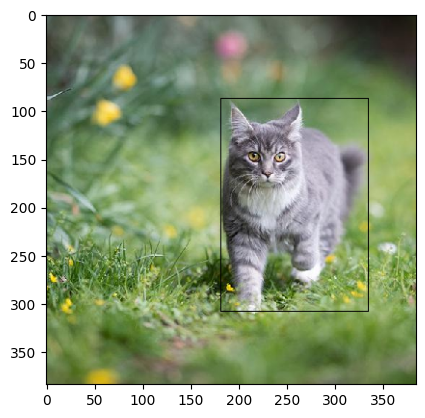

In [6]:
%matplotlib inline
im_res = np.array(image[0])
bbox = np.array(preds["detection_boxes"][0][0], dtype=np.int32)
cv2.rectangle(im_res, 
              (bbox[1],bbox[0]), (bbox[3],bbox[2]),
              color=(0,0,0))
plt.imshow(np.array(im_res, dtype=np.uint8))

- Check the predicted classes : # todo : include it in the visu

In [7]:
label = np.array(preds["detection_classes"][0][0], dtype=np.int32)

In [8]:
coco = pd.read_csv("./coco-labels-91.txt", header=None)

In [9]:
coco.iloc[label-1]

0    cat
Name: 16, dtype: object

## Explaining the detection result with Xplique

Depending on the detection dataset and use case, the bounding box (bbox) format, classes encoding, often differs. 
 - For example, the output of our Retinanet detection module is a Python dict, with one value the tensor with the bbox positions, one with the bbox classes (ordinal encoding), and one with the bbox score. 
Thus, we need to make our model compatible with the format expected by Xplique.
    - Xplique expect the following format for detection results :
        [batch_size, nb_bboxes, nb_classes+5]
        - the first dimension is the batch dimension
        - second is the number of bbox per image.
        - third is [x, y, x, y, conf, one_hot_cls]: 
                - the first 4 values are the bbox coordinates in xyxy format (xy top left, xy bottom right)
                - conf is the confidence score of the bbox
                - one_hot_cls is a one hot encoding of the bbox classe.
- Some model can also have specific pre/post-processing operations, like a separate non max suppression, which need to be called before/after the call of the model.

The proposed solution for both case is the implentation of a wrapper, with a __call__ method receiving the image,
applying your detection model, all the eventual pre/post processing operation, then converting your output to Xplique format described above.
Here is a wrapper for our Retinanet model :

In [10]:
class ModelWrapper():
    def __init__(self, model):
        self.model = model
        
    def __call__(self, x):
        preds = self.model.serve(x)
        return self.get_boxes_constant_size_map(preds)

    
    @staticmethod
    def get_boxes_constant_size_map(preds, nb_classes=91):
        preds= tf.concat([tf.expand_dims(preds["detection_boxes"][...,0], axis=-1),
                          tf.expand_dims(preds["detection_boxes"][...,2], axis=-1),
                          tf.expand_dims(preds["detection_boxes"][...,1], axis=-1),
                          tf.expand_dims(preds["detection_boxes"][...,3], axis=-1),
                          tf.expand_dims(preds["detection_scores"], axis=-1), 
                          tf.expand_dims(tf.cast(preds["detection_classes"], tf.float32), axis=-1)], axis=-1)
        def pred_loop(pred):
            boxes = pred[..., :4] 
            scores = pred[..., 4]
            cls = pred[..., 5]
            one_hot_cls = tf.cast(tf.one_hot(tf.cast(cls, tf.int32), nb_classes, 1), tf.float32)

            results = tf.concat([boxes, tf.expand_dims(scores, axis=-1),
                       one_hot_cls], axis=-1)
            return results
        batch_results = tf.map_fn(pred_loop, preds, infer_shape=False)
        return batch_results

    @property
    def layers(self):
        return self.model.layers

    @property
    def input(self):
        return self.model.input

    @property
    def output(self):
        return self.model.output

    @staticmethod
    def from_config(conf_wrapper):
        model_wrapper = conf_wrapper["model_wrapper"]
        config = conf_wrapper["config"]
        keras_model = model_wrapper.model.__class__.from_config(config)
        keras_model.decode_predictions = model_wrapper.model.decode_predictions
        return ModelWrapper(keras_model, model_wrapper.HEIGHT, model_wrapper.WIDTH,
                            model_wrapper.nb_classes, model_wrapper.threshold)

    def get_config(self):
        return {"config": self.model.get_config(), "model_wrapper": self}

    def get_weights(self):
        return self.model.get_weights()

    def set_weights(self, weights):
        return self.model.set_weights(weights)

To modify this wrapper for your specific detection model :
- modify the __call__ with the correct syntax to apply your detection model to _a batch of images_ add eventual pre/post processing if needed. 
- modify :
~~~ python
@staticmethod
    def get_boxes_constant_size_map(preds, nb_classes=91):
~~~ 
which convert the predictions _for a batch of images_ of your model to the Xplique format describe above.

- Attention : to ensures that your wrapper is compatible with the black box methods (based on gradient propagation), your methods must be compatible with gradient propagation. This means using a derivable non max suppression (or tf.stop_gradients if some parts of it are not), and having a get_boxes_constant_size_map with tensors and without loops (here we use tf.map_fn instead).

Import all the explanation methods and metrics we will use for detection

In [11]:
import os
from pathlib import Path
import numpy as np

from xplique.attributions import SobolAttributionMethod
from xplique.attributions import IntegratedGradients
from xplique.attributions import SmoothGrad, Saliency, DeconvNet, GradientInput, GuidedBackprop
from object_detector import BoxIouCalculator,ImageObjectDetectorScoreCalculator, YoloObjectFormater

import matplotlib.pyplot as plt
from xplique.plots.image import _normalize, _clip_percentile
from xplique.metrics import Deletion, Insertion, MuFidelity, AverageStability


methods = {
    "ig":IntegratedGradients,
    "saliency":Saliency,
    "deconvnet":DeconvNet,
    "gradient_input":GradientInput,
    "guided_backprop": GuidedBackprop,
    "sobol": SobolAttributionMethod,
    "smoothgrad": SmoothGrad
}
metrics = {
    "deletion": Deletion,
    "insertion": Insertion,
    "mufidelity": MuFidelity,
    "average_stability": AverageStability
}


The syntax is the same, whatever each explanation method to explain a model result :
- Create and instanciate a wrapper around our model :

~~~ python
    wrapper = ModelWrapper(model, img.shape[1], img.shape[2], nb_classes)
~~~

- provide an Xplique operator for tensorflow score calcution for a detection task
~~~ python
    params["operator"] = ImageObjectDetectorScoreCalculator(
        YoloObjectFormater(),BoxIouCalculator()).tf_batched_score
~~~
    
- instanciate the explanation method with the wrapped model, operator and eventual method specific parameters and apply it to the predictions we want to explain:
~~~
    explainer = explanation_method(wrapper, **params)
    return explainer.explain(img, wrapper.get_boxes_constant_size_map(preds))
~~~

Here are all this code in a single method :

In [45]:
def explain_prediction(model, explanation_method, preds, img, params):
    wrapper = ModelWrapper(model)
    params["operator"] = ImageObjectDetectorScoreCalculator(
            YoloObjectFormater(), BoxIouCalculator()).tf_batched_score
    explainer = explanation_method(wrapper, **params)
    return explainer.explain(img, wrapper.get_boxes_constant_size_map(preds)), explainer # Some metrics like AverageStability also need the explainer.

In [46]:
"""
method = "sobol"
params = {
    "batch_size": 16,
    "grid_size":16,
    "nb_design":32
}"""
"""
method = "saliency"
params = {
    "batch_size": 16
}"""

explanation_method = SmoothGrad
params = {
    "batch_size": 16,
    "nb_samples": 50,
    "noise": 0.069
}
# only keep the first bbox, rest is empty.
preds["detection_boxes"] = np.array(preds["detection_boxes"])
preds["detection_boxes"][0,1:,:] = 0
preds["detection_scores"] = np.array(preds["detection_scores"])
preds["detection_scores"][0,1:] = 0
preds["detection_classes"] = np.array(preds["detection_classes"])
preds["detection_classes"][0,1:] = 0
explanation, explainer = explain_prediction(det, explanation_method, preds, image, params)
print(explanation)

boxes_refs (100, None, 4)
class_refs (100, None, 91)
classification_similarity <unknown>
proba_detection <unknown>
boxes_pairwise_scores <unknown>
ref_boxes_scores <unknown>
image_score ()
Before batch loop
images_score TensorShape([None])
Before batch loop
images_score TensorShape([None])
Before batch loop
images_score TensorShape([None])
boxes_refs (100, None, 4)
class_refs (100, None, 91)
classification_similarity <unknown>
proba_detection <unknown>
boxes_pairwise_scores <unknown>
ref_boxes_scores <unknown>
image_score ()
Before batch loop
images_score TensorShape([None])
tf.Tensor(
[[[[ 4.9123305e-10  9.0655920e-11  1.7645339e-10]
   [-1.3009131e-10 -6.3080363e-10 -2.7376357e-10]
   [ 2.5451499e-10 -5.2146432e-10 -2.2932689e-10]
   ...
   [-4.4349626e-09  3.6630707e-10 -2.3809819e-09]
   [-5.5134781e-09 -1.5826545e-09 -2.6945850e-09]
   [-4.3990229e-09 -2.4108056e-09 -2.7763658e-09]]

  [[-8.4559491e-11 -5.0971982e-10 -1.4353091e-10]
   [ 5.7737405e-11 -3.0925040e-10  7.6481620e-11

Our explanation represent, for each pixel in the original image, its contribution to the model prediction.
We can visualize this explanation with the following method :

In [26]:
def visualize(explanation, image, alpha=0.5, cmap="jet", clip_percentile=0.5, figsize=(10,10)):
    image = image[-1]
    expl = explanation[-1]
    plt.figure(figsize=figsize)
    if image is not None:
        image = _normalize(image)
        plt.imshow(image)
    if expl.shape[-1] == 3:
        expl = np.mean(expl, -1)
    if clip_percentile:
        expl = _clip_percentile(expl, clip_percentile)
    if not np.isnan(np.max(np.min(expl))):
        expl = _normalize(expl)

    plt.imshow(expl, cmap=cmap, alpha=alpha)
    plt.axis('off')

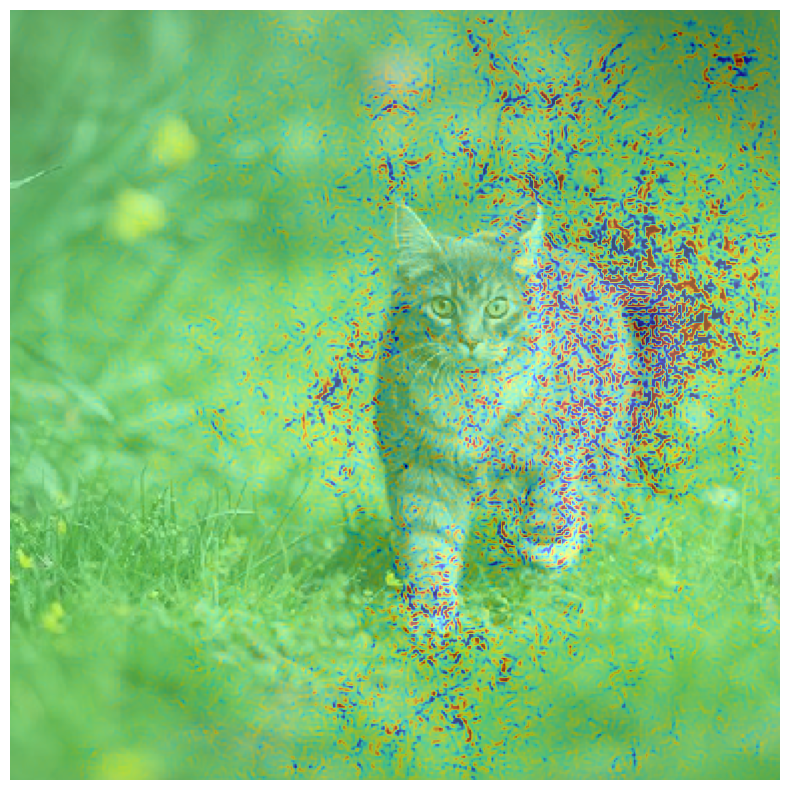

In [27]:
visualize(explanation, image, clip_percentile=0.9)

### Explanation metrics and scoring

- Xplique provides different metrics (Insertion, Deletion, AverageStability...)
    - AverageStability is based on the explainer, rather than the explanations, and as such requires a different syntax than the rest
    
Here is how to use them with a detection model and wrapper. It follows the same principle than how we applied the explanation methods to the detection. : we need to wrap our detection model, and provide the additionnal detection operator.

In [48]:
def get_explanation_score(model, method, explanation, img, preds, explainer_wrapper=None, params={}):
    wrapper = ModelWrapper(model)

    if method != AverageStability:
        params["operator"] = ImageObjectDetectorScoreCalculator(
            YoloObjectFormater(), BoxIouCalculator()).tf_batched_score
        metric = method(wrapper, np.array(img), wrapper.get_boxes_constant_size_map(preds), **params)
        return metric(explanation)

    metric = method(wrapper, np.array(img), wrapper.get_boxes_constant_size_map(preds), **params)
    return metric(explainer_wrapper)

Let's get our score :

In [43]:
get_explanation_score(det, Deletion, explanation, image, preds, params={"batch_size":16, "steps":30,"max_percentage_perturbed":0.5})

KeyboardInterrupt: 

In [ ]:
"""
for method in explainer.methods.keys():
    params = {
        "batch_size":16
    }
    
    explanation = explainer.apply(method, res, x2, params)
    explainer.visualize()
"""

In [49]:
get_explanation_score(det, AverageStability, explanation, image, preds, explainer, {"batch_size":16})

Before batch loop
images_score TensorShape([None])
Before batch loop
images_score TensorShape([None])
Before batch loop
images_score TensorShape([None])
Before batch loop
images_score TensorShape([None])
Before batch loop
images_score TensorShape([None])
Before batch loop
images_score TensorShape([None])
Before batch loop
images_score TensorShape([None])
Before batch loop
images_score TensorShape([None])
Before batch loop
images_score TensorShape([None])
Before batch loop
images_score TensorShape([None])
Before batch loop
images_score TensorShape([None])
Before batch loop
images_score TensorShape([None])
Before batch loop
images_score TensorShape([None])
Before batch loop
images_score TensorShape([None])
Before batch loop
images_score TensorShape([None])
Before batch loop
images_score TensorShape([None])
Before batch loop
images_score TensorShape([None])
Before batch loop
images_score TensorShape([None])
Before batch loop
images_score TensorShape([None])
Before batch loop
images_score 

KeyboardInterrupt: 